In [ ]:
# importing all the required libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torch.distributions 

from PIL import Image
import torchvision.utils
import numpy as np
import matplotlib.pyplot as plt

# checking for device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Files already downloaded and verified
Files already downloaded and verified
torch.Size([100, 3, 32, 32])
<class 'torchvision.datasets.cifar.CIFAR10'>


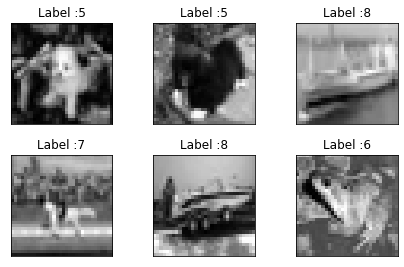

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

#downloading mnist dataset
train_data = CIFAR10('CIFAR10_Data', download = True,train = True, transform = transform) 
test_data =CIFAR10('CIFAR10_Data', download = True, train= False, transform = transform)

#Loading the data in data loader
BATCH_SIZE = 100
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE ,shuffle= True)
test_dataloader = DataLoader(test_data, batch_size= BATCH_SIZE, shuffle = True)

# showing some of the data samples
examples = enumerate(train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_data.shape)
print(type(train_data))
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title('Label :' + str(int(example_targets[i])))
  plt.xticks([])
  plt.yticks([])
fig.show()

In [ ]:
# class for encoder
class EncoderModule(nn.Module):
    def __init__(self, input_channels, output_channels, stride, kernel, pad):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=kernel, padding=pad, stride=stride)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class Encoder(nn.Module):
    def __init__(self, color_channels, pooling_kernels, n_neurons_in_middle_layer):
        self.n_neurons_in_middle_layer = n_neurons_in_middle_layer
        super().__init__()
        self.bottle = EncoderModule(color_channels, 32, stride=1, kernel=1, pad=0)
        self.m1 = EncoderModule(32, 64, stride=1, kernel=3, pad=1)
        self.m2 = EncoderModule(64, 128, stride=pooling_kernels[0], kernel=3, pad=1)
        self.m3 = EncoderModule(128, 256, stride=pooling_kernels[1], kernel=3, pad=1)

    def forward(self, x):
        out = self.m3(self.m2(self.m1(self.bottle(x))))
        return out.view(-1, self.n_neurons_in_middle_layer)


#class for decoder
class DecoderModule(nn.Module):
    def __init__(self, input_channels, output_channels, stride, activation="relu"):
        super().__init__()
        self.convt = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=stride, stride=stride)
        self.bn = nn.BatchNorm2d(output_channels)
        if activation == "relu":
            self.activation = nn.ReLU(inplace=True)
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.bn(self.convt(x)))

class Decoder(nn.Module):
    def __init__(self, color_channels, pooling_kernels, decoder_input_size):
        self.decoder_input_size = decoder_input_size
        super().__init__()
        self.m1 = DecoderModule(256, 128, stride=1)
        self.m2 = DecoderModule(128, 64, stride=pooling_kernels[1])
        self.m3 = DecoderModule(64, 32, stride=pooling_kernels[0])
        self.bottle = DecoderModule(32, color_channels, stride=1, activation="sigmoid")

    def forward(self, x):
        out = x.view(-1, 256, self.decoder_input_size, self.decoder_input_size)
        out = self.m3(self.m2(self.m1(out)))
        return self.bottle(out)



In [ ]:
# class for VAE
class VAE(nn.Module):
    def __init__(self,latent ,kernel,encoder_out_size, channels):
        super().__init__()
        self.n_latent_features = latent
        pooling_kernel = kernel
        encoder_output_size = encoder_out_size
        color_channels = channels

        n_neurons_middle_layer = 256 * encoder_output_size * encoder_output_size

        # Encoder
        self.encoder = Encoder(color_channels, pooling_kernel, n_neurons_middle_layer)
        # Middle
        self.fc1 = nn.Linear(n_neurons_middle_layer, self.n_latent_features)
        self.fc2 = nn.Linear(n_neurons_middle_layer, self.n_latent_features)
        self.fc3 = nn.Linear(self.n_latent_features, n_neurons_middle_layer)
        # Decoder
        self.decoder = Decoder(color_channels, pooling_kernel, encoder_output_size)

    def _reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def _bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self._reparameterize(mu, logvar)
        return z, mu, logvar
        
    def sampling(self):
        z = torch.randn(64, self.n_latent_features).to(device)
        z = self.fc3(z)
       
        return self.decoder(z)

    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self._bottleneck(h)
        z = self.fc3(z)
        d = self.decoder(z)
        return d, mu, logvar

In [ ]:
#Training VAE

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)        
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

latent_size = 64
kernel = [4,2]
encoder_out = 4
channels = 3
vae = VAE(latent_size, kernel, encoder_out, channels).to(device)



epochs = 25
learning_rate = 0.001
optimizer = torch.optim.Adam(vae.parameters(), lr = learning_rate)

losses = []
for epoch in range(epochs):
    for batch_idx, (inputs, _) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = vae(inputs)

        loss = loss_function(recon_batch, inputs, mu, logvar)
        loss.backward()
        optimizer.step()


    losses.append(loss)


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


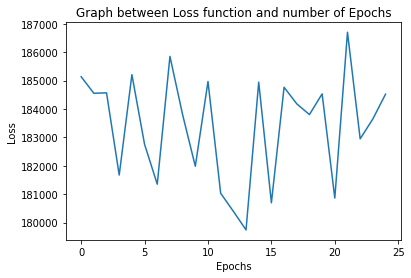

In [ ]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Graph between Loss function and number of Epochs")
plt.plot(losses)
plt.show()

In [ ]:
# saving model
PATH = 'saved_VAE_model.pth'
torch.save(vae, PATH)


In [ ]:
PATH = 'saved_VAE_model.pth'
#loading the model
vae_model = torch.load(PATH)


In [ ]:
from torchvision.utils import save_image

vae.eval()
val_loss = 0
samples_cnt = 0
for epoch in range(epochs):
    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            recon_batch, mu, logvar = vae(inputs)
            val_loss += loss_function(recon_batch, inputs, mu, logvar).item()
            samples_cnt += inputs.size(0)

            if batch_idx == 0:
                save_image(recon_batch, f"{'VAE'}.png", nrow=8)

        print(batch_idx, len(test_dataloader), f"ValLoss: {val_loss/samples_cnt:f}")

    save_image(vae.sampling(), f"{'VAE'}{str(epoch)}.png", nrow=8)


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


99 100 ValLoss: 1821.805717
99 100 ValLoss: 1821.765947
99 100 ValLoss: 1821.748315
99 100 ValLoss: 1821.732628
99 100 ValLoss: 1821.753036
99 100 ValLoss: 1821.753735
99 100 ValLoss: 1821.733498
99 100 ValLoss: 1821.724908
99 100 ValLoss: 1821.723095
99 100 ValLoss: 1821.725476
99 100 ValLoss: 1821.724579
99 100 ValLoss: 1821.730361
99 100 ValLoss: 1821.730407
99 100 ValLoss: 1821.734220
99 100 ValLoss: 1821.734590
99 100 ValLoss: 1821.734388
99 100 ValLoss: 1821.734025
99 100 ValLoss: 1821.739364
99 100 ValLoss: 1821.739500
99 100 ValLoss: 1821.738550
99 100 ValLoss: 1821.737431
99 100 ValLoss: 1821.742146
99 100 ValLoss: 1821.738590
99 100 ValLoss: 1821.743144
99 100 ValLoss: 1821.741991
